In [1]:
import torch
import torch.nn.functional as F
from torch import nn

from einops import rearrange
from einops.layers.torch import Rearrange

from traj_dataset import TrajDataset
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, Adagrad
from torch.nn import MSELoss
import matplotlib.pyplot as plt

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)


def posemb_sincos_3d(patches, temperature = 10000, dtype = torch.float32):
    _, f, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    z, y, x = torch.meshgrid(
        torch.arange(f, device=device),
        torch.arange(h, device=device),
        torch.arange(w, device=device),
        indexing='ij')

    fourier_dim = dim // 6

    omega = torch.arange(fourier_dim, device = device) / (fourier_dim - 1)
    omega = 1. / (temperature ** omega)

    z = z.flatten()[:, None] * omega[None, :]
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]

    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos(), z.sin(), z.cos()), dim = 1)

    pe = F.pad(pe, (0, dim - (fourier_dim * 6))) # pad if feature dimension not cleanly divisible by 6
    return pe.type(dtype)


# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim if out_dim else dim),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))


    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class SimpleViT(nn.Module):

    def __init__(self, *, image_size=(128, 128), image_patch_size=(32, 32), frames=4, frame_patch_size=2, dim, depth=6, heads=8, mlp_dim=512, channels=1, dim_head=64):
        super().__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by the frame patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf)', p1=patch_height, p2=patch_width, pf=frame_patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        ).to(self.device)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim).to(self.device)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 24)
        )




        self.decoderLayer = nn.TransformerDecoderLayer(d_model=dim,nhead=heads).to(self.device)

        self.decoder = nn.TransformerDecoder(self.decoderLayer,6).to(self.device)

        self.outputLinear = nn.Linear(dim,4).to(self.device)

    def forward(self, video):
        *_, h, w, dtype = *video.shape, video.dtype
        video = video.to(self.device)
        x = self.to_patch_embedding(video).to(self.device)
        pe = posemb_sincos_3d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        x = self.transformer(x)
        x = self.generate_sequence(x)
        x = self.outputLinear(x)
        return x

    def generate_sequence(self, memory, max_length=6):
        # Initialize the decoder input with a special start-of-sequence token
        decoder_input = torch.ones((1,50, 512)).to(self.device)

        # Initialize the decoder hidden state with the encoder output
        decoder_hidden = memory.transpose(0, 1)

        # Initialize a list to store the generated sequence
        generated_sequence = []

        # Generate the output sequence token by token
        for i in range(max_length):
            # Pass the decoder input and hidden state through the decoder
            decoder_output = self.decoder(tgt=decoder_input, memory=decoder_hidden)

            # Select the token with the highest probability as the output token

            # Append the output token to the generated sequence
            generated_sequence.append(decoder_output)

            # Use the output token as the input to the next decoder step
            decoder_input = decoder_output

        # Concatenate the generated sequence along the time dimension
        generated_sequence = torch.cat(generated_sequence, dim=0)
        generated_sequence = generated_sequence.transpose(0,1)

        return generated_sequence





In [2]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    model = SimpleViT(dim=512)



    optim = Adam(params=model.parameters(),lr=0.001)


Using device: cuda


In [3]:
dataset = TrajDataset("datasets/bookstore/video0", device, img_step=10,train=True,n_prev=8)

test_dataset = TrajDataset("datasets/bookstore/video0", device, img_step=10,train=False,n_prev=8)


opening track 0
opening track 1
opening track 2
opening track 3
opening track 4
opening track 5
opening track 6
opening track 7
opening track 8
opening track 9
opening track 10
opening track 11
opening track 12
opening track 13
opening track 14
opening track 15
opening track 16
opening track 17
opening track 18
opening track 19
opening track 20
opening track 21
opening track 22
opening track 23
opening track 24
opening track 25
opening track 26
opening track 27
opening track 28
opening track 29
opening track 30
opening track 31
opening track 32
opening track 33
opening track 34
opening track 35
opening track 36
opening track 37
opening track 38
opening track 39
opening track 40
opening track 41
opening track 42
opening track 43
opening track 44
opening track 45
opening track 46
opening track 47
opening track 48
opening track 49
opening track 180
opening track 181
opening track 182
opening track 183
opening track 184
opening track 185
opening track 186
opening track 187
opening track 18

In [4]:
batch_size = 50
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
criterion = MSELoss()

loss_evol = []

test_loss = []

for id_b, batch in enumerate(test_loader):

    print(f"Test Batch {id_b}")
    if len(batch["X"]) != batch_size: continue
    model.eval()

    X_test = batch["X"]
    Y_test = batch["Y"]


    pred = model(X_test.to(device))
    l = criterion(pred,Y_test.to(device))
    test_loss.append(l.item())

for epoch in range(5):
    print("Starting epoch: ", epoch)
    for id_b, batch in enumerate(train_loader):
        print(f"Batch {id_b}")
        if len(batch["X"]) != batch_size: continue

        model.train()
        X_train = batch["X"]
        Y_train = batch["Y"]

        optim.zero_grad()
        pred = model(X_train.to(device))
        l = criterion(pred, Y_train.to(device))
        loss_evol.append(l.item())
        l.backward()
        optim.step()


        if id_b % 50 == 0:
            for id_b2, batch_test in enumerate(test_loader):

                print(f"Test Batch {id_b2}")
                if len(batch_test["X"]) != batch_size: continue
                model.eval()

                X_test = batch_test["X"]
                Y_test = batch_test["Y"]

                pred = model(X_test.to(device))
                l = criterion(pred,Y_test.to(device))
                test_loss.append(l.item())






Test Batch 0
Test Batch 1
Test Batch 2
Test Batch 3
Test Batch 4
Test Batch 5
Test Batch 6
Test Batch 7
Test Batch 8
Test Batch 9
Test Batch 10
Test Batch 11
Test Batch 12
Test Batch 13
Test Batch 14
Test Batch 15
Test Batch 16
Test Batch 17
Test Batch 18
Test Batch 19
Test Batch 20
Test Batch 21
Test Batch 22
Test Batch 23
Test Batch 24
Test Batch 25
Test Batch 26
Test Batch 27
Starting epoch:  0
Batch 0
Test Batch 0
Test Batch 1
Test Batch 2
Test Batch 3
Test Batch 4
Test Batch 5
Test Batch 6
Test Batch 7
Test Batch 8
Test Batch 9
Test Batch 10
Test Batch 11
Test Batch 12
Test Batch 13
Test Batch 14
Test Batch 15
Test Batch 16
Test Batch 17
Test Batch 18
Test Batch 19
Test Batch 20
Test Batch 21
Test Batch 22
Test Batch 23
Test Batch 24
Test Batch 25
Test Batch 26
Test Batch 27
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Ba

0.12173011015492974
[0.5550493001937866, 18.226593017578125, 0.7975655794143677, 0.6012881398200989, 0.2243129014968872, 0.23862309753894806, 0.35687029361724854, 0.23358909785747528, 0.1381073296070099, 0.15160436928272247, 0.19420892000198364, 0.19998669624328613, 0.15871763229370117, 0.11803153157234192, 0.12243201583623886, 0.13624072074890137, 0.14196708798408508, 0.15030616521835327, 0.10929445922374725, 0.11562593281269073, 0.1434839367866516, 0.10986942797899246, 0.12451725453138351, 0.11649800837039948, 0.1366225779056549, 0.1179383248090744, 0.10695942491292953, 0.10576079785823822, 0.09611007571220398, 0.07821525633335114, 0.10050603747367859, 0.10612934082746506, 0.1222861036658287, 0.11377082020044327, 0.10439828783273697, 0.12681010365486145, 0.14135368168354034, 0.11883105337619781, 0.10277941823005676, 0.15995460748672485, 0.14282606542110443, 0.10797494649887085, 0.13534726202487946, 0.1310843676328659, 0.10905960202217102, 0.12024398893117905, 0.13410639762878418, 0.1

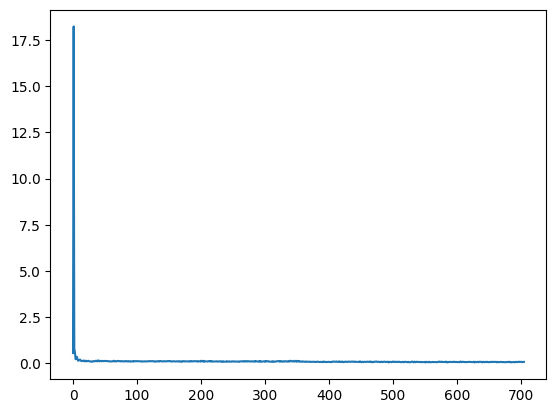

In [5]:
import numpy as np

print(np.mean(loss_evol))
print(loss_evol)
plt.plot(loss_evol)
print(loss_evol)
plt.show()

1.3784943117449682


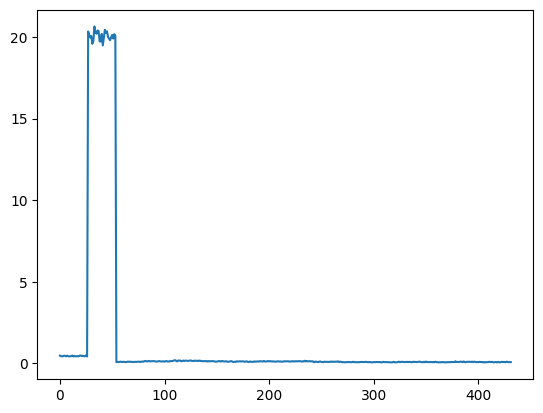

In [6]:
print(np.mean(test_loss))
plt.plot(test_loss)
plt.show()


Test Batch 0
torch.Size([6, 4])
[(0.42247045, 0.5574875), (0.42247045, 0.55748755), (0.42247042, 0.5574875), (0.42247045, 0.55748755), (0.42247045, 0.5574875), (0.42247045, 0.55748755)]
[(tensor(0.9646), tensor(0.5816)), (tensor(0.9286), tensor(0.5816)), (tensor(0.8975), tensor(0.5844)), (tensor(0.8685), tensor(0.5863)), (tensor(0.8359), tensor(0.5863)), (tensor(0.8069), tensor(0.5946))]


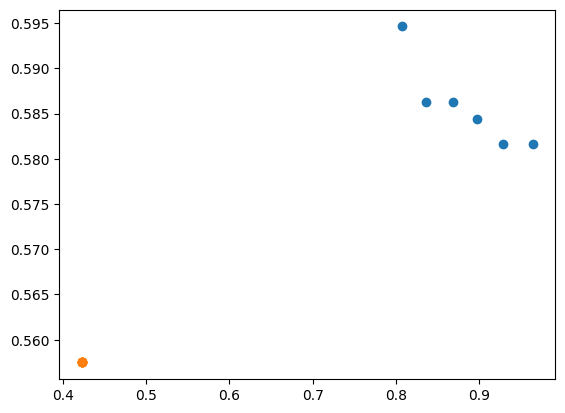

In [8]:
for id_b2, batch_test in enumerate(test_loader):

                print(f"Test Batch {id_b2}")
                if len(batch_test["X"]) != batch_size: continue
                model.eval()

                X_test = batch_test["X"]
                Y_test = batch_test["Y"]
                print(Y_test[0].shape)
                pred = model(X_test.to(device))
                points = [(k[0],k[1]) for k in Y_test[7]]
                points2 = [(k[0],k[1]) for k in pred[7].cpu().detach().numpy()]
                x,y = zip(*points)
                x2,y2 = zip(*points2)
                print(points2)
                print(points)
                plt.scatter(x,y, label="Truth")
                plt.scatter(x2,y2,label="Prediction")
                plt.show()
                break
